# NGC Kreek OAall GWAS
__Author__: Jesse Marks <br>
__Date__: November 30, 2018

I am using this document to investigate the Kreek_EA cohort group. More specifically, the previous OAall GWAS for Kreek_EA have had inflated lambda values. So, we imposed some very strict thresholds of:

```
Action Description	Thresholding Criteria
For EA retainment	(AFR < 5%) ∧ (EAS < 5%)
```

in an attempt to reduce this inflation. 

__Genotype Data Location__: s3:rti-heroin/kreek/data/genotype/original/20181128

## Variable information
### NGC Protocol Specifications
* OAall (coded 1 for all controls, 2 for OA cases)
* Sex (coded 1 for female, 2 for male)
* Any additional covariates (coded 1 for no, 2 for yes)
* Age (years)

### Kreek
#### genotype data (n=1200)
`wc -l aa_chr_all.fam` <br>
* 690 

`wc -l ea_chr_all.fam` <br>
* 624

#### phenotype data (n=1661)
Note, I will remap these to be consistent with the NGC protocol. 
[`affection_status`](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs001109.v1.p1&phv=261892&phd=6837&pha=&pht=5447&phvf=1&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1) <br>
* Case control status of the subject for opioid dependence
* 1 is opioid_dependence, 2 is no_opioid_dependence 
* 864 cases, 797 controls - total 1,661

[__OAall Variables__](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/dataset.cgi?study_id=phs001109.v1.p1&phv=261892&phd=6837&pha=&pht=5447&phvf=1&phdf=&phaf=&phtf=1&dssp=1&consent=&temp=1):
`Female (sex)` <br>
* 1 is male, 2 is female (Note, I will remap these to be consistent with the NGC protocol.)
* 1040 males, 616 females - total 1,656 (5 are missing sex data)

`Ageatint` <br>
* Age (integer) - total 1,661

**other variables**:
`opioid_dep      cocaine_dep     alcohol_dep   nicotine_dep     cannabis_dep    stimulant_dep   sedative_dep    other_dep       opioid_abuse    cocaine_abuse   alcohol_abuse   cannabis_abuse  stimulant_abuse        sedative_abuse  other_abuse`

# Filter genotype data
I will filter the final genotype data with the list of subjects to keep that was output during the Structure analysis when I applied the more stringent filter of:

| Action Description | Thresholding Criteria      |
|--------------------|----------------------------|
| For EA retainment | (AFR < 5%) ∧ (EAS < 5%) |

In [ ]:
## bash (EC2) ##


### create directory structure
genoD=/shared/data/studies/heroin/kreek/genotype/observed/final/filtered
gwasD=/shared/data/studies/heroin/kreek/gwas/oaall/003
phenoD=/shared/data/studies/heroin/kreek/phenotype/003
eig=/shared/data/studies/heroin/kreek/eig/003
study=kreek
mkdir -p $genoD $gwasD $eig/results $phenoD/{final,processing,unprocessed}

cd /shared/data/studies/heroin/kreek/genotype/observed/final/filtered

for ancestry in ea; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $genD/../ea_chr_all \
        --keep /shared/data/studies/heroin/kreek/genotype/observed/processing/002/ea/updated_subject_ids.keep \
        --make-bed \
        --out $genD/ea_chr_all
done

wc -l /shared/data/studies/heroin/kreek/genotype/observed/final/filtered/*fam
556 ea_chr_all.fam

# Prepare files for rvTest

## Phenotype processing
Create phenotype files for rvtest. We follow the instructions of the NGC protocol distributed by Eric Johnson. This protocol mandates that we create a phenotype file and a covariate file in PED format. See the NGC protocol for more information on this format. There are several initial filters and processing steps to be applied to the subject data

* Remove the age outlier (age 111) individual and 5 individuals with missing age data
* Remove phenotype data for all drugs except cocaine, opioids, and alcohol
* Combine dependence and abuse variables into one outcome variable per drug (opioid_abdp, cocaine_abdp, alcohol_abdp). Using the NGC protocol coding (Cases=2 and Controls=1)
 
    * Abuse and dependence = 2
    * Abuse or dependence = 2
    * No abuse and no dependence = 1
    * Note: In the original data True=1 and False=0
* Map sex coding, per the NGC protocol, to 1=female & 2=male. Currently, the mapping is reversed.
    
* Note that we decided to not include Hispanic group. Also, we do not partition by ancestry because during the genotype QC processing some of the subjects were reassigned to a group disparate from there there self-reported ancestry group.

In [ ]:
## R console ##
# Load data
setwd("/shared/data/studies/heroin/kreek/phenotype/003")
pheno.data <- read.delim("unprocessed/phs001109.v1.pht005447.v1.p1.c1.Addictive_Diseases_Subject_Phenotypes.DS-ADX-IRB-NPU.txt",
                         stringsAsFactors=F, skip=10)

# Remove extra column data
pheno.data <- pheno.data[,-1*c(6,7,8,12,13,14,15,16,20,21,22,23)]

# Remove age outlier and NAs
pheno.data <- pheno.data[-1*which(is.na(pheno.data$age)),]
pheno.data <- pheno.data[-1*which(pheno.data$age==111),]

# Combine dependence and abuse variables
opioid.abdp <- as.logical(pheno.data$opioid_dep) | as.logical(pheno.data$opioid_abuse)
cocaine.abdp <- as.logical(pheno.data$cocaine_dep) | as.logical(pheno.data$cocaine_abuse)
alcohol.abdp <- as.logical(pheno.data$alcohol_dep) | as.logical(pheno.data$alcohol_abuse)

# convert to NGC protocol coding (Case=2, control=1)
opioid_abdp <- c()
opioid_abdp[opioid.abdp] <- 2
opioid_abdp[!opioid.abdp] <- 1

cocaine_abdp <- c()
cocaine_abdp[cocaine.abdp] <- 2
cocaine_abdp[!cocaine.abdp] <- 1

alcohol_abdp <- c()
alcohol_abdp[alcohol.abdp] <- 2
alcohol_abdp[!alcohol.abdp] <- 1

# map sex to 1=female 2=male
sex_mapped <- c()
sex_mapped[which(pheno.data$sex==2)] <- 1
sex_mapped[which(pheno.data$sex==1)] <- 2

pheno.data <- cbind(pheno.data, sex_mapped, opioid_abdp, cocaine_abdp, alcohol_abdp)
pheno.data <- subset(pheno.data, select=-c(sex, opioid_dep, opioid_abuse, cocaine_dep, cocaine_abuse, alcohol_dep, alcohol_abuse))

# Partition by ancestry
#ea.data <- pheno.data[pheno.data$family_race=="White",]
#aa.data <- pheno.data[pheno.data$family_race=="African_American",]
#ha.data <- pheno.data[pheno.data$family_race=="Hispanic",]

#write.table(x = ea.data, file = "processing/ea.phenotype.data", quote = F, row.names = F)
#write.table(x = aa.data, file = "processing/aa.phenotype.data", quote = F, row.names = F)
#write.table(x = ha.data, file = "processing/ha.phenotype.data", quote = F, row.names = F)
write.table(x = pheno.data, file="processing/phenotype_table_sex+abpd_mapped.tsv", quote = F, row.names = F, sep = "\t")

Filter down to subjects with both genotype data (in \*fam plink file) and phenotype data.

In [ ]:
### Bash ###

# get IDs of subjects with genotype data
cut -d ' ' -f2 $genoD/ea_chr_all.fam > $phenoD/processing/$study.ea.genotype.IDs
#cut -d ' ' -f2 $genoD/aa_chr_all.fam > $phenoD/processing/$study.aa.genotype.IDs

# if subject has genotype data, then keep
## AAs
#awk 'NR==FNR{a[$1];next} FNR==1{print $0;next} FNR>=2{ if($2 in a) {print $0}}' \
#    $study.aa.genotype.IDs phenotype_table_sex+abpd_mapped.tsv >\
#    $study.aa.phenotype_table

# EAs
awk 'NR==FNR{a[$1];next} FNR==1{print $0;next} FNR>=2{ if($2 in a) {print $0}}' \
    $phenoD/processing/$study.ea.genotype.IDs $phenoD/processing/phenotype_table_sex+abpd_mapped.tsv >\
    $phenoD/processing/$study.ea.phenotype_table
                    

 wc -l $phenoD/processing/*table
"""
  557 kreek.ea.phenotype_table
"""

In [ ]:
#copy to local machine 

cd /home/jmarks/Desktop/Projects/heroin/ngc/kreek/20181130/phenotype
scp -i ~/.ssh/gwas_rsa ec2-user@54.90.227.178:/shared/data/studies/heroin/kreek/phenotype/003/processing/*table .

In [3]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
setwd('C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/phenotype')

ea.data <- read.table("kreek.ea.phenotype_table", header=T, colClasses = 
                      c(rep("double",  3), "character", rep("double", 4)))
#aa.data <- read.table("kreek.aa.phenotype_table",  header = T,  colClasses =  
                      #c(rep("double",  3), "character", rep("double", 4)))

print("Head of EA table")
head(ea.data)
#print("Head of AA table")
#head(aa.data)
print("EA:1 is female 2 is male.")
table(ea.data$sex_mapped)
print("EA: age")
table(ea.data$age)
print("EA: Case/control - 1 is control & 2 is case")
table(ea.data$opioid_abdp)
#print("AA:1 is female 2 is male.")
#table(aa.data$sex_mapped)
#print("AA: Age")
#table(aa.data$age)
#print("AA:Case/control - 1 is control & 2 is case")
#table(aa.data$opioid_abdp)

[1] "Head of EA table"


dbGaP_Subject_ID,SUBJECT_ID,age,family_race,sex_mapped,opioid_abdp,cocaine_abdp,alcohol_abdp
1543710,100004,56,White,2,2,1,1
1543601,100006,22,White,2,2,1,1
1543092,100007,22,White,1,2,1,1
1543955,100025,46,White,1,2,1,1
1544218,100032,45,White,1,1,2,2
1543899,100033,45,White,1,2,1,1


[1] "EA:1 is female 2 is male."



  1   2 
216 340 

[1] "EA: age"



17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
 6  6 15  8 11 16 14 18 10  8 15 13 14 12 10 15 11  9  5 11 16  7  7 10  9 11 
43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 
12 14 18 23 24 23 13 10 12 14  9 13 15 10  9  7  3 10  5  4  3  6  1  2  4  1 
69 70 71 
 1  1  2 

[1] "EA: Case/control - 1 is control & 2 is case"



  1   2 
188 368 

### PCA (EIGENSTRAT)
To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. Usually a GRCh37 plus strand check is implemented, as well as a monomorphic SNP filter and discordant allele flip. Since this was already done for data in preparation for haplotype phasing, the haplotype phasing input PLINK files will be used. 

**Note**: In addition to these aforementioned data processing steps, ambiguous SNPs identified by reference panel frequency differences in the discordant allele checks were also removed prior to phasing.

#### Remove high-LD region variants

In [ ]:
### Bash (EC2 console)###


#for ancestry in {ea,aa};do
for ancestry in ea;do
    # Generate list of variants in known high-LD regions
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }'\
    $genoD/${ancestry}_chr_all.bim > $eig/${ancestry}.high_ld_regions.remove
done
            

# Remove SNPs in known high-LD regions
#for ancestry in {ea,aa};do
for ancestry in ea;do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/${ancestry}_chr_all \
        --exclude $eig/${ancestry}.high_ld_regions.remove \
        --make-bed \
        --out $eig/${ancestry}_high_ld_regions_removed
done

 wc -l $eig/*bim
"""
    499953 ea_high_ld_regions_removed.bim
"""

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
### EC2 console ###

#for ancestry in {ea,aa};do
for ancestry in ea;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name $study.${ancestry}.chr${chr}.ld_prune \
            --script_prefix $eig/${ancestry}_chr${chr}_ld_prune \
            --mem 3 \
            --nslots 2 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3000 \
                --bfile $eig/${ancestry}_high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out $eig/${ancestry}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
#for ancestry in {aa,ea};do
for ancestry in ea;do
    cat $eig/${ancestry}_chr*_ld_pruned.prune.in > $eig/${ancestry}_chr_all_ld_pruned.prune.in
done


# Create new PLINK filesets with only lD pruned variants
for ancestry in ea;do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${ancestry}_high_ld_regions_removed \
        --extract $eig/${ancestry}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/${ancestry}_ld_pruned
done

# Clean up
#for ancestry in {aa,ea};do
for ancestry in ea;do
    rm $eig/*${ancestry}*ld_pruned.{prune.in,prune.out,log}
    rm $eig/*${ancestry}*ld_prune*qsub*
    rm $eig/*${ancestry}*high_ld_regions*
    rm $eig/*${ancestry}*chr23_ld_pruned.hh
done

""" wc -l *bim
  135043 ea_ld_pruned.bim
"""

#### Rename BIM/FAM file IDs
BIM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. FAM file IDs are treated similarly.

In [ ]:
### EC2 console ###

# Count ID lengths greater than 39 characters
# an example of an rsID that is too long is the following:
# rs141233280:245974067:GAAAGACGCACTTTTC:G
#for ancestry in {aa,ea};do
for ancestry in ea;do
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned.bim | wc -l
done
# output is
"""
0
1
"""


# Rename BIM file IDs
#for ancestry in {aa,ea};do
for ancestry in ea;do
    awk '{$2="ID_"NR; print $0}' $eig/${ancestry}_ld_pruned.bim \
        > $eig/${ancestry}_ld_pruned_id_renamed.bim
done

## Rename FAM file IDs
#awk '{$1="ID_"NR; print $0}' ${ancestry}_ld_pruned.fam > ${ancestry}_ld_pruned_id_renamed.fam
#done

**Note** we did not have to rename the FAM files for this case.

#### Assign Cases and Controls
Modify the fam file to include case/control status. According to PLINK,

`Phenotype value ('1' = control, '2' = case, '-9'/'0'/non-numeric = missing data if case/control)`

The NGC protocol is consistent with this assignment.

In [ ]:
# EC2 command line #

# 6th column corresponds to variable opioid_abdp
#for ancestry in {ea,aa};do
for ancestry in ea;do
    tail -n +2 $phenoD/processing/$study.$ancestry.phenotype_table |\
        awk '{ if ($6==1) {print $2}}' > $eig/$ancestry.controls.ids

    # Modify FAM file to include case/control status
    awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
        $eig/$ancestry.controls.ids $eig/${ancestry}_ld_pruned.fam > $eig/${ancestry}_ld_pruned.case+control.mapped.fam
done

#### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT `bin` directory should be part of the PATH variable.

The `smartpca.pl` program documentation is shown below:

DOCUMENTATION of `smartpca.pl` program:

This program calls the smartpca program (see ../POPGEN/README). 
For this to work, the bin directory containing smartpca MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
### EC2 console ###

# Run smartpca
#for ancestry in {ea,aa}; do
for ancestry in ea; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.${ancestry}_smartpca \
        --script_prefix $eig/smartpca.$study.${ancestry} \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i $eig/${ancestry}_ld_pruned.bed \
            -a $eig/${ancestry}_ld_pruned_id_renamed.bim \
            -b $eig/${ancestry}_ld_pruned.case+control.mapped.fam \
            -o $eig/results/${ancestry}_ld_pruned.pca \
            -p $eig/results/${ancestry}_ld_pruned.plot \
            -e $eig/results/${ancestry}_ld_pruned.eval \
            -l $eig/results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### Extract Eigenvectors

In [ ]:
### EC2 console ###
#cd $eig/results

# Grab top 10 eigenvectors from PCA 
#for ancestry in {ea,aa};do
for ancestry in ea;do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
done

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [1]:
#cd /home/jmarks/Desktop/Projects/heroin/ngc/kreek/20181130/eig
#scp -i ~/.ssh/gwas_rsa ec2-user@54.90.227.178:/shared/data/studies/heroin/kreek/eig/003/results/* .

### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/eig/")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
ea.evec[,1:5]
ea.evec[,6:11]
#aa.evec <- read.table("aa_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
#aa.evec[,6:11]

,V2,V3,V4,V5,V6
0:100004,0.0000,0.0153,0.0057,0.0000,-0.0304
0:100006,0.0261,-0.0015,-0.0003,-0.0026,0.0030
0:100007,0.0339,0.0079,-0.0091,0.0096,-0.0180
0:100025,-0.0104,0.0237,0.0348,-0.0257,-0.0103
0:100032,-0.0986,-0.0336,-0.0087,-0.0055,-0.0195
0:100033,0.0196,-0.0037,-0.0144,0.0025,-0.0167
0:100047,0.0262,0.0174,-0.0100,0.0097,-0.0009
0:100112,0.0305,0.0027,-0.0125,0.0089,-0.0209
0:100149,0.0355,0.0083,-0.0092,0.0128,-0.0296
0:100191,0.0273,0.0257,0.0138,0.0033,-0.0164


,V7,V8,V9,V10,V11,V12
0:100004,-0.0129,0.0111,0.0076,-0.0071,-0.0193,Case
0:100006,-0.0110,-0.0021,0.0107,-0.0165,0.0377,Case
0:100007,0.0364,0.0259,-0.0118,0.0182,-0.0057,Case
0:100025,-0.0077,-0.0080,0.0277,-0.0217,0.0014,Case
0:100032,-0.0332,-0.0172,0.0014,-0.0696,0.0231,Control
0:100033,-0.0074,-0.0139,-0.0113,0.0135,-0.0072,Case
0:100047,0.0010,-0.0196,-0.0011,0.0157,0.0078,Case
0:100112,0.0142,0.0079,-0.0075,0.0012,-0.0012,Case
0:100149,0.0168,-0.0038,-0.0166,0.0019,0.0042,Control
0:100191,0.0221,0.0159,-0.0012,0.0068,-0.0115,Case


##### EA

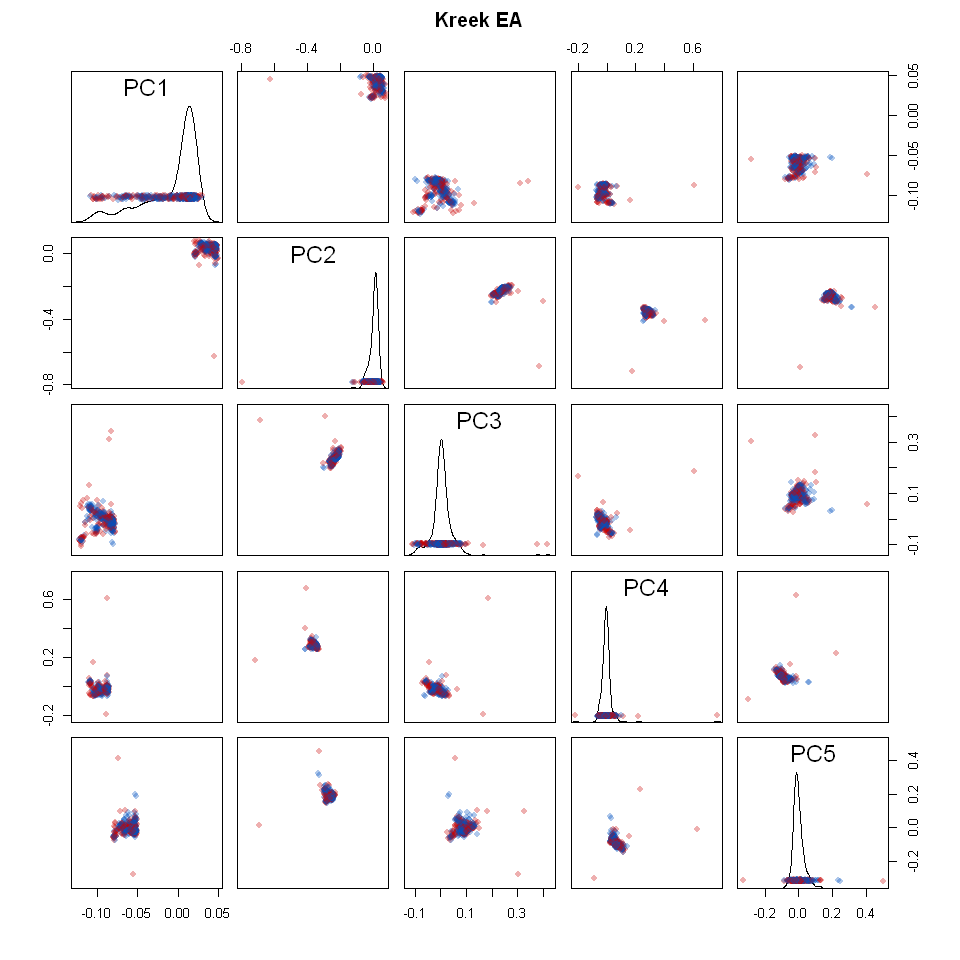

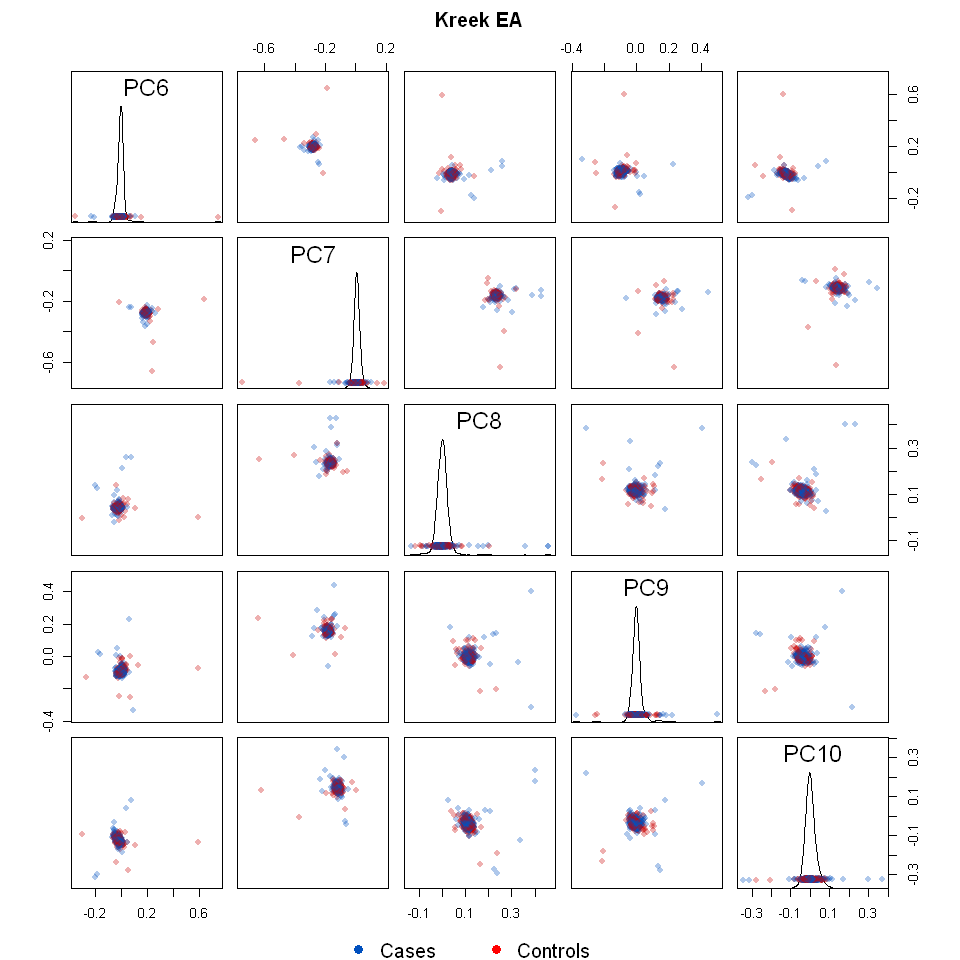

In [2]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- ea.evec[,11]
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

###label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek EA", cex.main=1)
legend("bottom", c("Cases", "Controls"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


##### AA

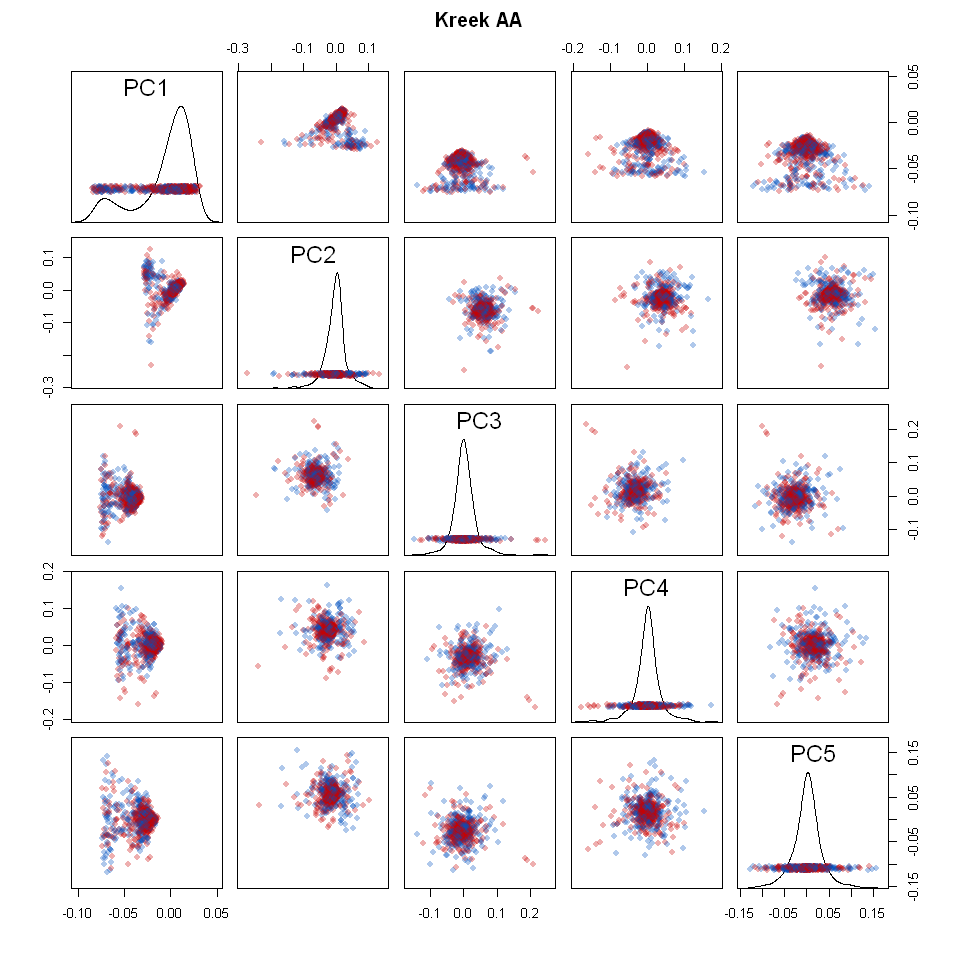

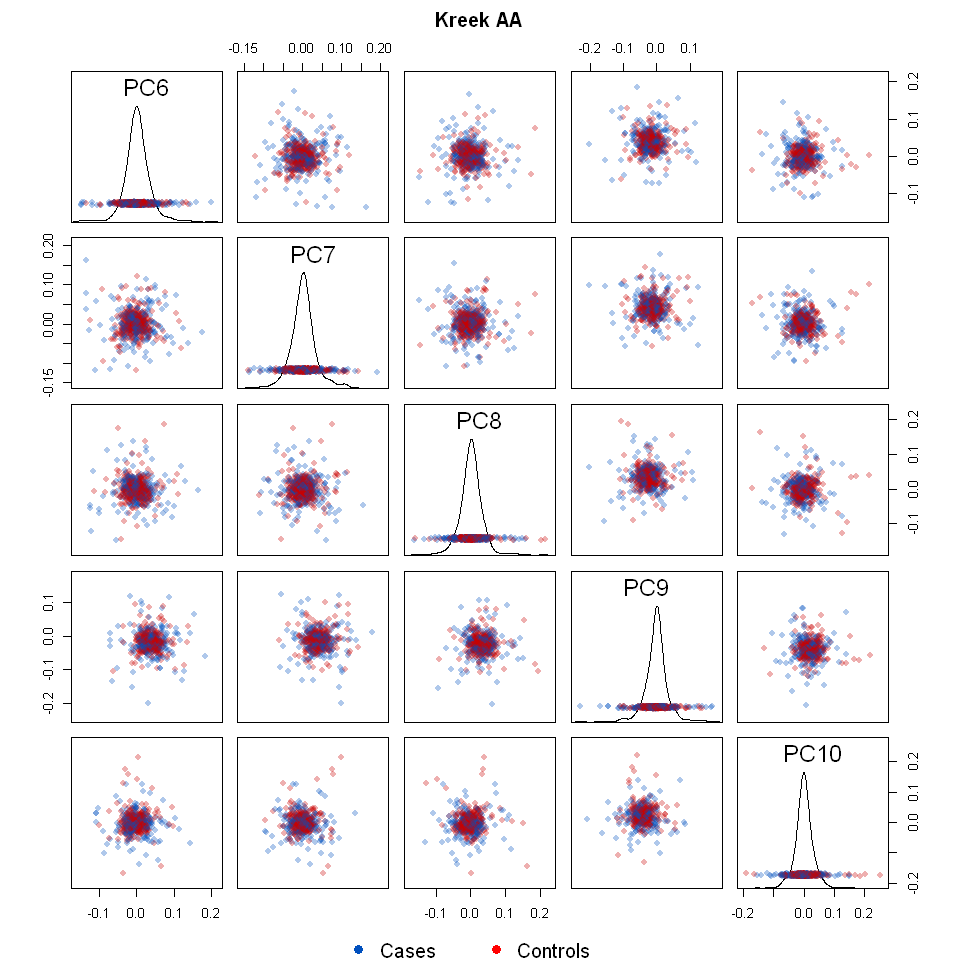

In [4]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- aa.evec[,11]
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

###label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek AA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Kreek AA", cex.main=1)
legend("bottom", c("Cases", "Controls"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


### EA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.
Make PED format phenotype and covariate file according to the NGC protocol.

#### Create PED files
The covariates we want to include in this baseline GWAS are age, sex, and some of the most influential PCs. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain  ∼75%  of the variance.

In [3]:
#mkdir /cygdrive/c/Users/jmarks/Desktop/Projects/heroin/ngc/kreek/20181113/phenotype/final

### R (local) ###

## Phen file
#------------------------------------------------------------------------------------------
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/phenotype")
p.data <- "kreek.ea.phenotype_table"
pheno.data.ea <- read.csv(p.data, sep = "\t", header = TRUE, stringsAsFactors = F, 
                       colClasses=c(rep("double",  3), "character", rep("double", 4)))

head(pheno.data.ea)
pca.data.ea <- read.csv("../eig/ea_ld_pruned_top10_eigenvecs.txt",
                     sep = " " , header=T, colClasses=c(rep("character",times=2), rep("double",times = 10)))

num.subjects.ea <- length(pca.data.ea[,1])

ped.file.ea <- data.frame(matrix(ncol = 6, nrow = num.subjects.ea))
colnames(ped.file.ea) <- c("fid", "iid", "patid", "matid", "sex",  "oaall")
ped.file.ea[,1] <- 0
ped.file.ea[,2] <- pheno.data.ea[,2]
ped.file.ea[,"sex"] <- pheno.data.ea[,"sex_mapped"]
ped.file.ea[,"oaall"] <- pheno.data.ea[,"opioid_abdp"]


head(ped.file.ea)
write.table(ped.file.ea[,1:6], "kreek_EUR_phen.ped", sep = "\t", row.names = F, quote=F)


#----------------------------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude oaall data)
col.names.ea <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.ea <- length(col.names.ea)
covar.data.ea <- data.frame(matrix(ncol = num.columns.ea, nrow = num.subjects.ea))
names(covar.data.ea) <- col.names.ea

num.covs.ea <- length(ped.file.ea) - 1
covar.data.ea[,1:num.covs.ea] <- ped.file.ea[,1:num.covs.ea] # fid, iid, patid, matic, sex
covar.data.ea[,num.covs.ea+1] <- pheno.data.ea[,3] # age 

covar.data.ea[,(num.covs.ea+2):length(col.names.ea)] <- pca.data.ea[,3:length(pca.data.ea)]

head(covar.data.ea)
length(covar.data.ea[,1])

write.table(covar.data.ea, "kreek_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

dbGaP_Subject_ID,SUBJECT_ID,age,family_race,sex_mapped,opioid_abdp,cocaine_abdp,alcohol_abdp
1543710,100004,56,White,2,2,1,1
1543601,100006,22,White,2,2,1,1
1543092,100007,22,White,1,2,1,1
1543955,100025,46,White,1,2,1,1
1544218,100032,45,White,1,1,2,2
1543899,100033,45,White,1,2,1,1


fid,iid,patid,matid,sex,oaall
0,100004,NA,NA,2,2
0,100006,NA,NA,2,2
0,100007,NA,NA,1,2
0,100025,NA,NA,1,2
0,100032,NA,NA,1,1
0,100033,NA,NA,1,2


fid,iid,patid,matid,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,100004,NA,NA,2,56,0.0000,0.0153,0.0057,0.0000,-0.0304,-0.0129,0.0111,0.0076,-0.0071,-0.0193
0,100006,NA,NA,2,22,0.0261,-0.0015,-0.0003,-0.0026,0.0030,-0.0110,-0.0021,0.0107,-0.0165,0.0377
0,100007,NA,NA,1,22,0.0339,0.0079,-0.0091,0.0096,-0.0180,0.0364,0.0259,-0.0118,0.0182,-0.0057
0,100025,NA,NA,1,46,-0.0104,0.0237,0.0348,-0.0257,-0.0103,-0.0077,-0.0080,0.0277,-0.0217,0.0014
0,100032,NA,NA,1,45,-0.0986,-0.0336,-0.0087,-0.0055,-0.0195,-0.0332,-0.0172,0.0014,-0.0696,0.0231
0,100033,NA,NA,1,45,0.0196,-0.0037,-0.0144,0.0025,-0.0167,-0.0074,-0.0139,-0.0113,0.0135,-0.0072


[1] 556

In [4]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/phenotype/")
options(stringsAsFactors=F)
ea.cov.data <- read.delim("kreek_EUR_cov.ped", header=T, sep="\t")
ea.phen.data <- read.delim("kreek_EUR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "oaall"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(ea.data)

iid,oaall,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
100004,2,0.0000,0.0153,0.0057,0.0000,-0.0304,-0.0129,0.0111,0.0076,-0.0071,-0.0193
100006,2,0.0261,-0.0015,-0.0003,-0.0026,0.0030,-0.0110,-0.0021,0.0107,-0.0165,0.0377
100007,2,0.0339,0.0079,-0.0091,0.0096,-0.0180,0.0364,0.0259,-0.0118,0.0182,-0.0057
100025,2,-0.0104,0.0237,0.0348,-0.0257,-0.0103,-0.0077,-0.0080,0.0277,-0.0217,0.0014
100032,1,-0.0986,-0.0336,-0.0087,-0.0055,-0.0195,-0.0332,-0.0172,0.0014,-0.0696,0.0231
100033,2,0.0196,-0.0037,-0.0144,0.0025,-0.0167,-0.0074,-0.0139,-0.0113,0.0135,-0.0072


#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [5]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)

# Get sequential (type I) sum of squares
anova.ea <- anova(lm.fit.ea)

# Calculate percent variance explained and sort
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
summary(lm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 oaall ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EA group ================


Call:
lm(formula = as.formula(model.str), data = ea.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7551 -0.6182  0.2787  0.3119  0.7810 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.66187    0.01968  84.429  < 2e-16 ***
PC1          1.86543    0.46413   4.019 6.66e-05 ***
PC2          1.26428    0.46414   2.724  0.00666 ** 
PC3         -0.01324    0.46416  -0.029  0.97725    
PC4         -1.06941    0.46415  -2.304  0.02160 *  
PC5          0.03561    0.46416   0.077  0.93887    
PC6         -0.37833    0.46415  -0.815  0.41537    
PC7          0.41422    0.46413   0.892  0.37255    
PC8          0.37415    0.46413   0.806  0.42051    
PC9          0.14958    0.46409   0.322  0.74734    
PC10         0.57212    0.46413   1.233  0.21823    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4641 on 545 degrees of freedom
Multiple R-squared:  0.05647,	Adjusted R-squared:  0.03916 
F-statisti

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC1,1,3.4792338506,3.4792338506,1.615085e+01,6.672214e-05,49.51
PC2,1,1.5985449761,1.5985449761,7.420559e+00,6.655207e-03,22.75
PC4,1,1.1434992964,1.1434992964,5.308205e+00,2.160050e-02,16.27
PC10,1,0.3273226277,0.3273226277,1.519455e+00,2.182335e-01,4.66
PC7,1,0.1715499351,0.1715499351,7.963470e-01,3.725817e-01,2.44
PC6,1,0.1431711488,0.1431711488,6.646106e-01,4.152930e-01,2.04
PC8,1,0.1400074124,0.1400074124,6.499243e-01,4.204914e-01,1.99
PC9,1,0.0223914384,0.0223914384,1.039426e-01,7.472723e-01,0.32
PC5,1,0.0012650211,0.0012650211,5.872318e-03,9.389452e-01,0.02
PC3,1,0.0001738624,0.0001738624,8.070818e-04,9.773462e-01,0.00


#### Percent Variance Explained Visualization

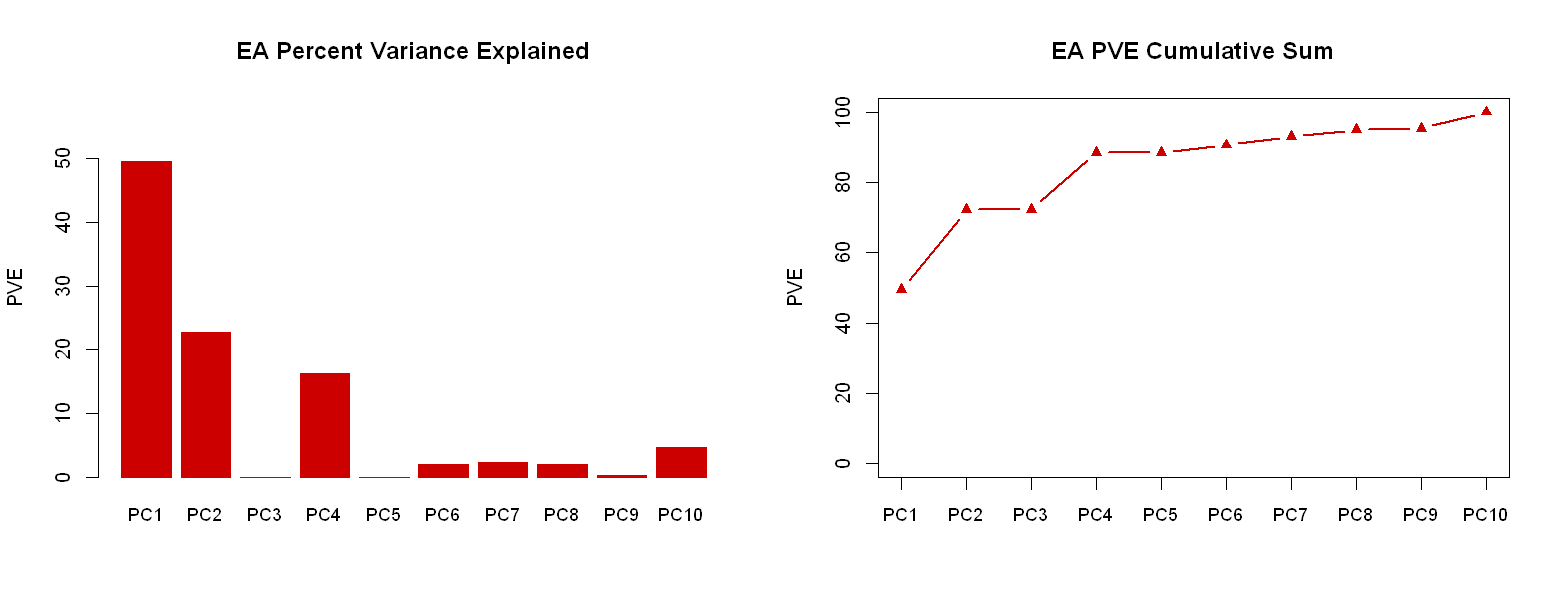

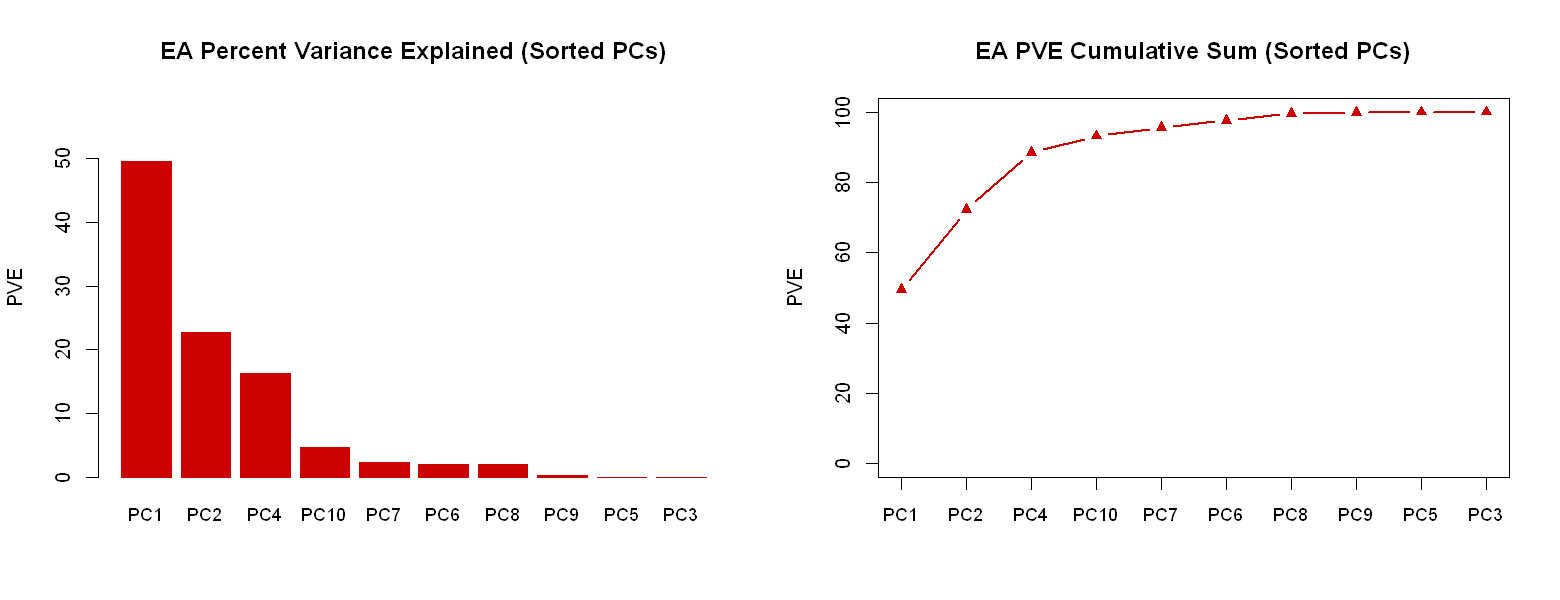

In [6]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.ea = c(0, max(ea.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC1, PC2, and PC4. These PCs explain ~88% of the variance. 

### AA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.
Make PED format phenotype and covariate file according to the NGC protocol.

#### Create PED files
The covariates we want to include in this baseline GWAS are age, sex, and some of the most influential PCs. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain  ∼75%  of the variance.

In [36]:
### R (local) ###

## Phen file
#------------------------------------------------------------------------------------------
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181128/phenotype")
p.data <- "kreek.aa.phenotype_table"
pheno.data.aa <- read.csv(p.data, sep = "\t", header = TRUE, stringsAsFactors = F, 
                       colClasses=c(rep("double",  3), "character", rep("double", 4)))

head(pheno.data.aa)
pca.data.aa <- read.csv("../eig/aa_ld_pruned_top10_eigenvecs.txt",
                     sep = " " , header=T, colClasses=c(rep("character",times=2), rep("double",times = 10)))

num.subjects.aa <- length(pca.data.aa[,1])

ped.file.aa <- data.frame(matrix(ncol = 6, nrow = num.subjects.aa))
colnames(ped.file.aa) <- c("fid", "iid", "patid", "matid", "sex",  "oaall")
ped.file.aa[,1] <- 0
ped.file.aa[,2] <- pheno.data.aa[,2]
ped.file.aa[,"sex"] <- pheno.data.aa[,"sex_mapped"]
ped.file.aa[,"oaall"] <- pheno.data.aa[,"opioid_abdp"]


head(ped.file.aa)
write.table(ped.file.aa[,1:6], "kreek_AFR_phen.ped", sep = "\t", row.names = F, quote=F)


#----------------------------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude oaall data)
col.names.aa <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.aa <- length(col.names.aa)
covar.data.aa <- data.frame(matrix(ncol = num.columns.aa, nrow = num.subjects.aa))
names(covar.data.aa) <- col.names.aa

num.covs.aa <- length(ped.file.aa) - 1
covar.data.aa[,1:num.covs.aa] <- ped.file.aa[,1:num.covs.aa] # fid, iid, patid, matic, sex
covar.data.aa[,num.covs.aa+1] <- pheno.data.aa[,3] # age 

covar.data.aa[,(num.covs.aa+2):length(col.names.aa)] <- pca.data.aa[,3:length(pca.data.aa)]

head(covar.data.aa)
length(covar.data.aa[,1])

write.table(covar.data.aa, "kreek_AFR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

dbGaP_Subject_ID,SUBJECT_ID,age,family_race,sex_mapped,opioid_abdp,cocaine_abdp,alcohol_abdp
1543617,100002,34,African_American,2,1,1,1
1543808,100008,50,African_American,2,2,2,1
1542741,100027,52,African_American,2,2,1,2
1542991,100063,44,African_American,1,2,2,1
1544365,100070,52,African_American,1,1,1,1
1544268,100073,37,African_American,1,1,2,1


fid,iid,patid,matid,sex,oaall
0,100002,NA,NA,2,1
0,100008,NA,NA,2,2
0,100027,NA,NA,2,2
0,100063,NA,NA,1,2
0,100070,NA,NA,1,1
0,100073,NA,NA,1,1


fid,iid,patid,matid,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,100002,NA,NA,2,34,0.0288,0.0486,0.0000,0.0237,-0.0025,0.0146,0.0034,0.0071,0.0214,0.0190
0,100008,NA,NA,2,50,0.0006,-0.0380,0.0016,0.0110,-0.0846,0.0338,-0.0223,-0.0038,0.0103,0.0088
0,100027,NA,NA,2,52,0.0042,-0.0217,-0.0404,0.0097,0.0578,0.0032,0.0504,-0.0388,0.0049,-0.0109
0,100063,NA,NA,1,44,0.0339,0.0102,-0.0032,0.0010,-0.0004,0.0016,0.0033,-0.0089,0.0108,-0.0121
0,100070,NA,NA,1,52,0.0034,0.0218,-0.0099,0.0020,0.0179,0.0396,-0.0443,0.0355,0.0346,0.0533
0,100073,NA,NA,1,37,0.0356,0.0035,-0.0038,0.0022,-0.0010,-0.0015,0.0195,0.0012,-0.0042,-0.0070


[1] 690

In [37]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181128/phenotype")
options(stringsAsFactors=F)
aa.cov.data <- read.delim("kreek_AFR_cov.ped", header=T, sep="\t")
aa.phen.data <- read.delim("kreek_AFR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "oaall"
pc.names <- paste0("PC", 1:10)
aa.data <- merge(x=aa.phen.data[,c("iid",phen.name)], y=aa.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(aa.data)

iid,oaall,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
100002,1,0.0288,0.0486,0.0000,0.0237,-0.0025,0.0146,0.0034,0.0071,0.0214,0.0190
100008,2,0.0006,-0.0380,0.0016,0.0110,-0.0846,0.0338,-0.0223,-0.0038,0.0103,0.0088
100027,2,0.0042,-0.0217,-0.0404,0.0097,0.0578,0.0032,0.0504,-0.0388,0.0049,-0.0109
100063,2,0.0339,0.0102,-0.0032,0.0010,-0.0004,0.0016,0.0033,-0.0089,0.0108,-0.0121
100070,1,0.0034,0.0218,-0.0099,0.0020,0.0179,0.0396,-0.0443,0.0355,0.0346,0.0533
100073,1,0.0356,0.0035,-0.0038,0.0022,-0.0010,-0.0015,0.0195,0.0012,-0.0042,-0.0070


#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [38]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.aa <- lm(formula=as.formula(model.str), data=aa.data)

# Get sequential (type I) sum of squares
anova.aa <- anova(lm.fit.aa)

# Calculate percent variance explained and sort
aa.pve <- cbind(anova.aa[pc.names,], 
                PVE=round(anova.aa[pc.names, "Mean Sq"]/sum(anova.aa[pc.names, "Mean Sq"])*100, digits=2))
aa.pve.sorted <- aa.pve[order(aa.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ AA group ================")
summary(lm.fit.aa)
aa.pve.sorted

MODEL FORMULA:

 oaall ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AA group ================


Call:
lm(formula = as.formula(model.str), data = aa.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8835 -0.3866 -0.3340  0.5751  0.7486 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.41739    0.01845  76.807  < 2e-16 ***
PC1         -2.33823    0.48477  -4.823 1.74e-06 ***
PC2          0.58346    0.48476   1.204   0.2292    
PC3          0.29886    0.48474   0.617   0.5377    
PC4          0.74886    0.48476   1.545   0.1229    
PC5          0.53110    0.48475   1.096   0.2736    
PC6          0.48114    0.48475   0.993   0.3213    
PC7         -0.06160    0.48473  -0.127   0.8989    
PC8         -0.43913    0.48475  -0.906   0.3653    
PC9         -0.59164    0.48475  -1.220   0.2227    
PC10        -0.84935    0.48475  -1.752   0.0802 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4847 on 679 degrees of freedom
Multiple R-squared:  0.0491,	Adjusted R-squared:  0.0351 
F-statistic:

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC1,1,5.46688644,5.46688644,23.26522244,1.743557e-06,66.35
PC10,1,0.72140866,0.72140866,3.07007163,8.019734e-02,8.76
PC4,1,0.56077495,0.56077495,2.38646880,1.228557e-01,6.81
PC9,1,0.35003531,0.35003531,1.48963206,2.226972e-01,4.25
PC2,1,0.34051662,0.34051662,1.44912375,2.290881e-01,4.13
PC5,1,0.28209614,0.28209614,1.20050592,2.736091e-01,3.42
PC6,1,0.23146990,0.23146990,0.98505772,3.213069e-01,2.81
PC8,1,0.19286367,0.19286367,0.82076266,3.652786e-01,2.34
PC3,1,0.08932929,0.08932929,0.38015530,5.377268e-01,1.08
PC7,1,0.00378903,0.00378903,0.01612483,8.989910e-01,0.05


#### Percent Variance Explained Visualization

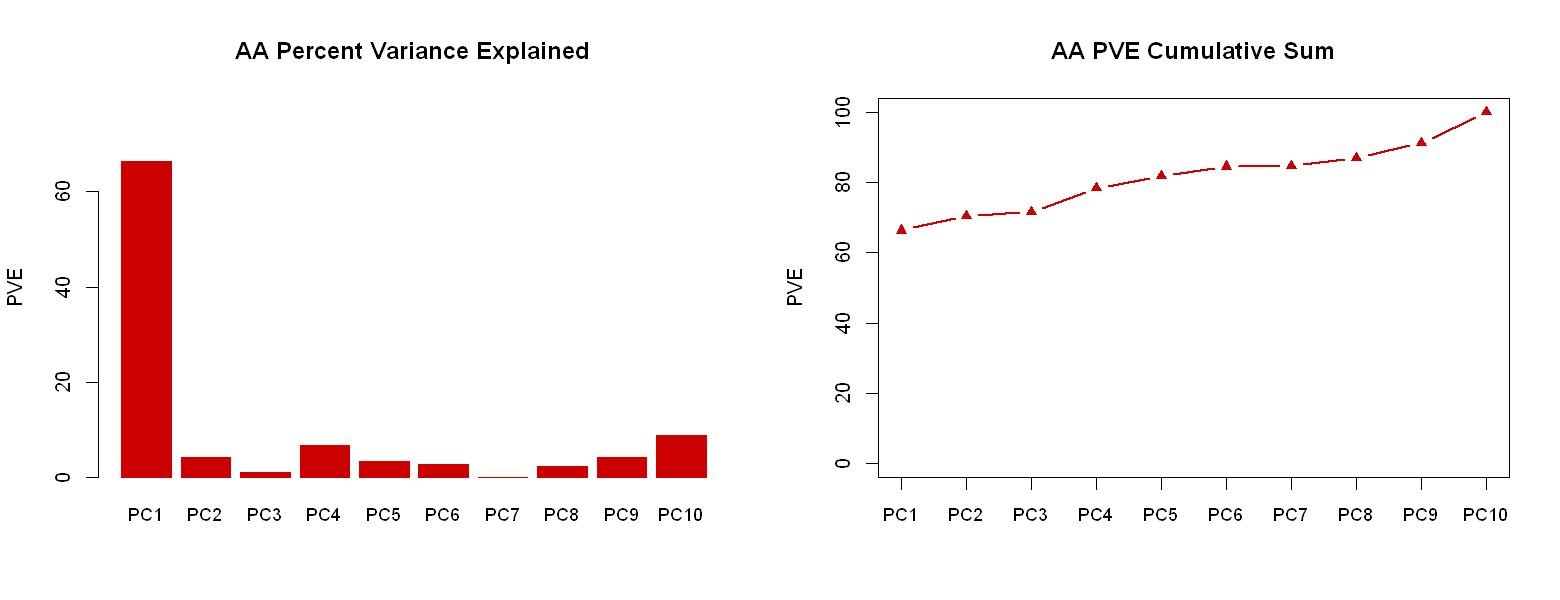

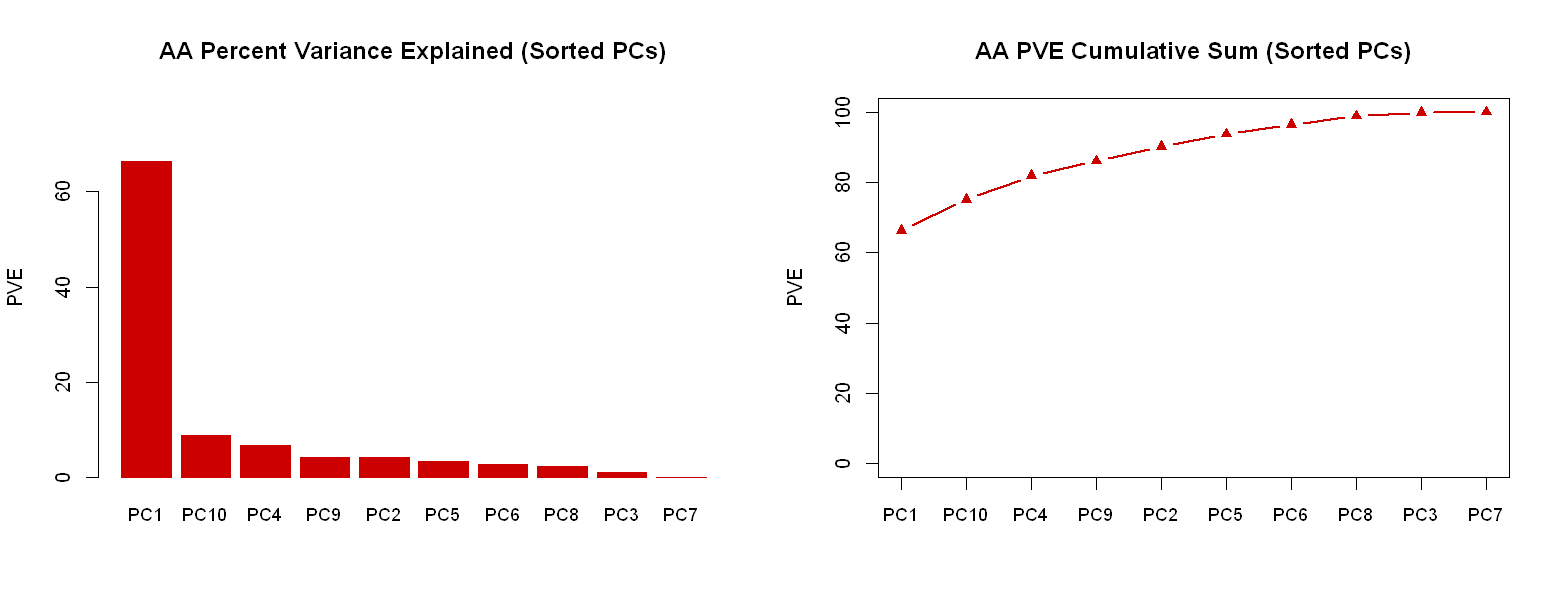

In [39]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.aa = c(0, max(aa.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=aa.pve$PVE, names.arg=rownames(aa.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, 
        main="AA Percent Variance Explained", ylab="PVE")
plot(cumsum(aa.pve$PVE), type="b", main="AA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=aa.pve.sorted$PVE, names.arg=rownames(aa.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, main="AA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(aa.pve.sorted$PVE), type="b", main="AA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC1 & PC10. These PCs explain ~75% of the variance. 

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
#upload to EC2
cd /home/jmarks/Desktop/Projects/heroin/ngc/kreek/20181130/phenotype
scp -i ~/.ssh/gwas_rsa kreek_* ec2-user@54.90.227.178:/shared/data/studies/heroin/kreek/phenotype/003/processing

### Bash (EC2 console) ###
cd /shared/data/studies/heroin/kreek/phenotype/003/processing

### AA ##
#awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_AFR_cov.ped > ../final/kreek_NGCW1_AFR_cov.ped
#awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_AFR_phen.ped > ../final/kreek_NGCW1_AFR_phen.ped

## EA ##
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_EUR_cov.ped > ../final/kreek_NGCW1_EUR_cov.ped
awk 'BEGIN{ OFS = "\t"} NR>=2{ $2=$1"_"$2} {print $0 }' kreek_EUR_phen.ped > ../final/kreek_NGCW1_EUR_phen.ped

## Genotype Data
Prepare Genotype Data for rvTest.
### Inflate imputation results
These data were imputed on the Michigan Imputation Server and therefore need to be inflated.

# Start rvTest Analysis
## Version 001
Perform GWAS

| Ancestry | cases | controls | Total |
|----------|-------|----------|-------|
| AFR      |    |       |    |
| EUR      |    |       |    |


**Note** you can find a description of the output from [rvtest here](https://genome.sph.umich.edu/wiki/Summary_Statistics_Files_Specification_for_RAREMETAL_and_rvtests).

### AA GWAS
PC1 & PC10

In [ ]:
# Command line # 
ancestry="aa"
covars="sex,age,PC1,PC10"
version=001

if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi

genD=/shared/data/studies/heroin/kreek/genotype/imputed/20181128/$ancestry
procD=/shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/processing
phenD=/shared/data/studies/heroin/kreek/phenotype/final

mkdir -p /shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/{final,processing}

for chr in {1..22};do
    mkdir -p /shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing/chr$chr
done


# Run RVtest
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix $procD/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
            --pheno-name oaall \
            --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
            --covar-name $covars \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/chr$chr/$study.$pop.1000G.oaall.chr$chr
done

### EA GWAS
Add PC1, PC2, & PC4

In [ ]:
# Command line # 
ancestry="ea"
covars="sex,age,PC1,PC2,PC4"
version=003

if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi

genD=/shared/data/studies/heroin/kreek/genotype/imputed/20181128/$ancestry
procD=/shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/processing
phenD=/shared/data/studies/heroin/kreek/phenotype/$version/final

mkdir -p /shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/{final,processing}

for chr in {1..22};do
    mkdir -p /shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing/chr$chr
done


# Run RVtest
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix $procD/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
            --pheno-name oaall \
            --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
            --covar-name $covars \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/chr$chr/$study.$pop.1000G.oaall.chr$chr
done

### Results Processing
#### MAF > 0.01 & Rsq > 0.3
Need to add a filter by population MAF too.

In [ ]:
### EC2 console ###
cd /shared/data/studies/heroin/kreek/gwas/oaall/$version 

# Get list of variants to filter by imputation quality and MAF
for ancestry in {ea,aa};do
    genD=/shared/data/studies/heroin/kreek/genotype/imputed/20181128/$ancestry
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing
    phenD=/shared/data/studies/heroin/$study/phenotype/$version/final

    for chr in {1..22}; do
        echo -e "${ancestry} chr${chr}..."
        zcat $genD/chr${chr}.info.gz | \
            tail -n +2 | \
            awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
            > $procD/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
    done
done

    

# Filter results files
#for ancestry in {ea,aa}; do
for ancestry in ea; do
    if [ $ancestry == "aa" ]; then
        pop=AFR
    else
        pop=EUR
    fi
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry
    for chr in {1..22}; do
        echo "processing $ancestry chr${chr}..."
        awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
            $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
            <(zgrep -P "^${chr}\s" $procD/processing/chr$chr/${study}.${pop}.1000G.oaall.chr${chr}.MetaScore.assoc.gz) \
            > $procD/processing/chr$chr/${study}.${ancestry}.1000G.oaall.chr${chr}.tmp
    done 
    cat $procD/processing/chr*/${study}.${ancestry}.1000G.oaall.chr*tmp | gzip -c > $procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz

    # cleanup
    rm $procD/processing/chr*/*tmp 
done

# Make results table
#for ancestry in {ea,aa}; do
for ancestry in ea; do
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry
    outfile=$procD/processing/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    infile=$procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz
    echo "Processing ${infile}"
    zcat ${infile} | \
        perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                    } else {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                    }' >> $outfile
done

# Make Q-Q and manhattan plots
# Plot all chromosomes
#for ancestry in {ea,aa};do
for ancestry in ea;do
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name gwas_plots_${ancestry} \
        --script_prefix $procD/final/${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
        --mem 30 \
        --nslots 7 \
        --priority 0 \
        --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
            --in $procD/processing/$study.$ancestry.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table \
            --in_chromosomes autosomal_nonPAR \
            --in_header \
            --out $procD/final/$study.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
            --col_id VARIANT_ID \
            --col_chromosome CHR \
            --col_position POSITION \
            --col_p P \
            --col_variant_type TYPE \
            --generate_snp_indel_manhattan_plot \
            --manhattan_odd_chr_color red3 \
            --manhattan_even_chr_color dodgerblue3 \
            --manhattan_points_cex 1.5 \
            --generate_snp_indel_qq_plot \
            --qq_lines \
            --qq_points_bg black \
            --qq_lambda
done

####   SNP lookup (EA)
rs3778150 and rs1799971 search
Dana wanted to pull out the chr. 6 results for the OPRM1 SNPs rs3778150 and rs1799971. My results are of the form chr_position and not rsIDs. So, I used the website [dbSNP](https://www.ncbi.nlm.nih.gov/projects/SNP/) to look up the positions for these two snps. Note that we are using genome build 37.

__CHROM   POS     REF     ALT     N_INFORMATIVE   AF      INFORMATIVE_ALT_AC      CALL_RATE       HWE_PVALUE      N_REF   N_HET   N_ALT   U_STAT  SQRT_V_STAT ALT_EFFSIZE PVALUE STAT    ALT_EFFSIZE     PVALUE__

```
6       154383658       T       C       614     0.170205        209.012 1       0.887298        423     173     18      9.82408 13.1991 0.0563903     0.456695

6       154360797       A       G       614     0.119425        146.654 1       0.847724        477     128     9       6.36378 11.3874 0.0490756     0.576268
```

### View plots

#### EA

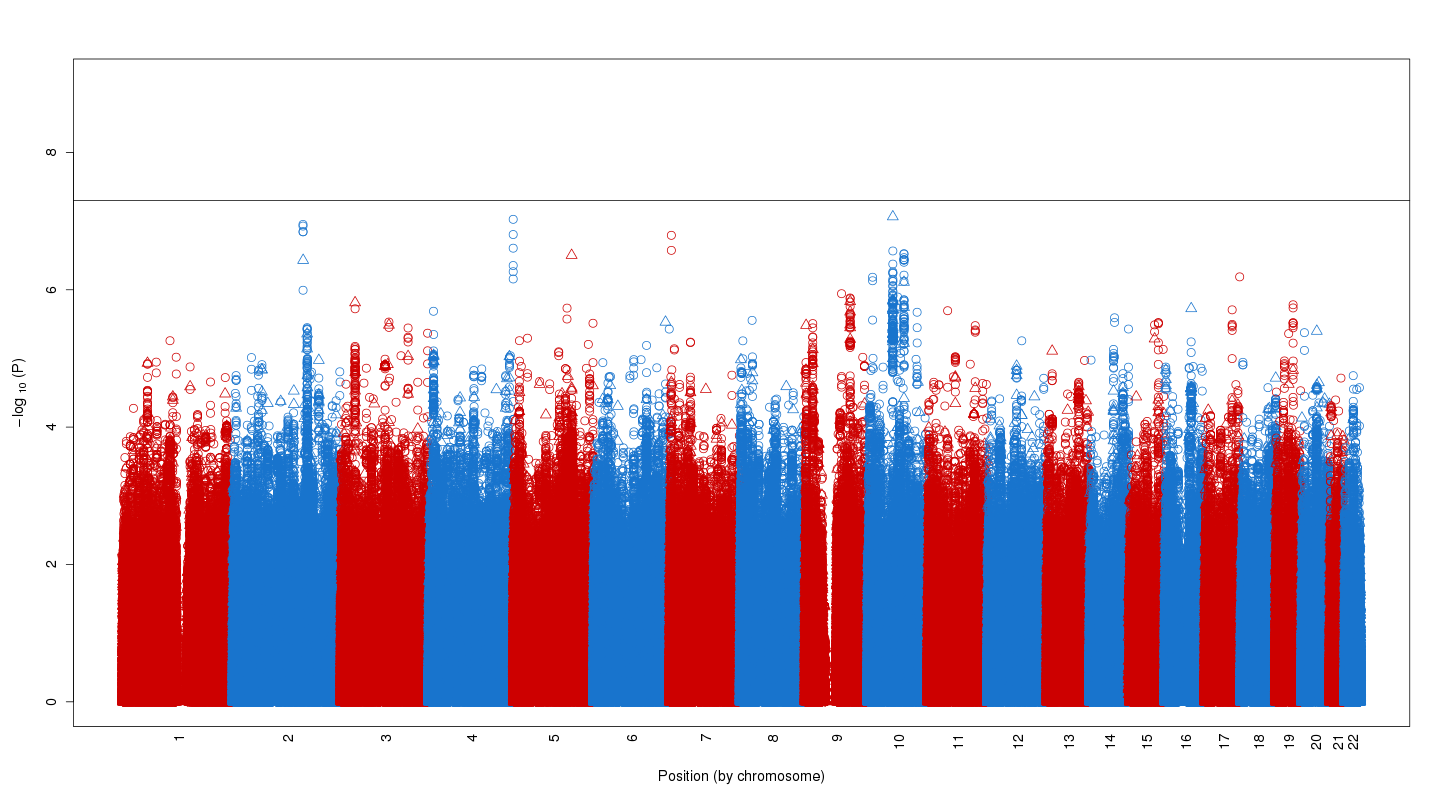

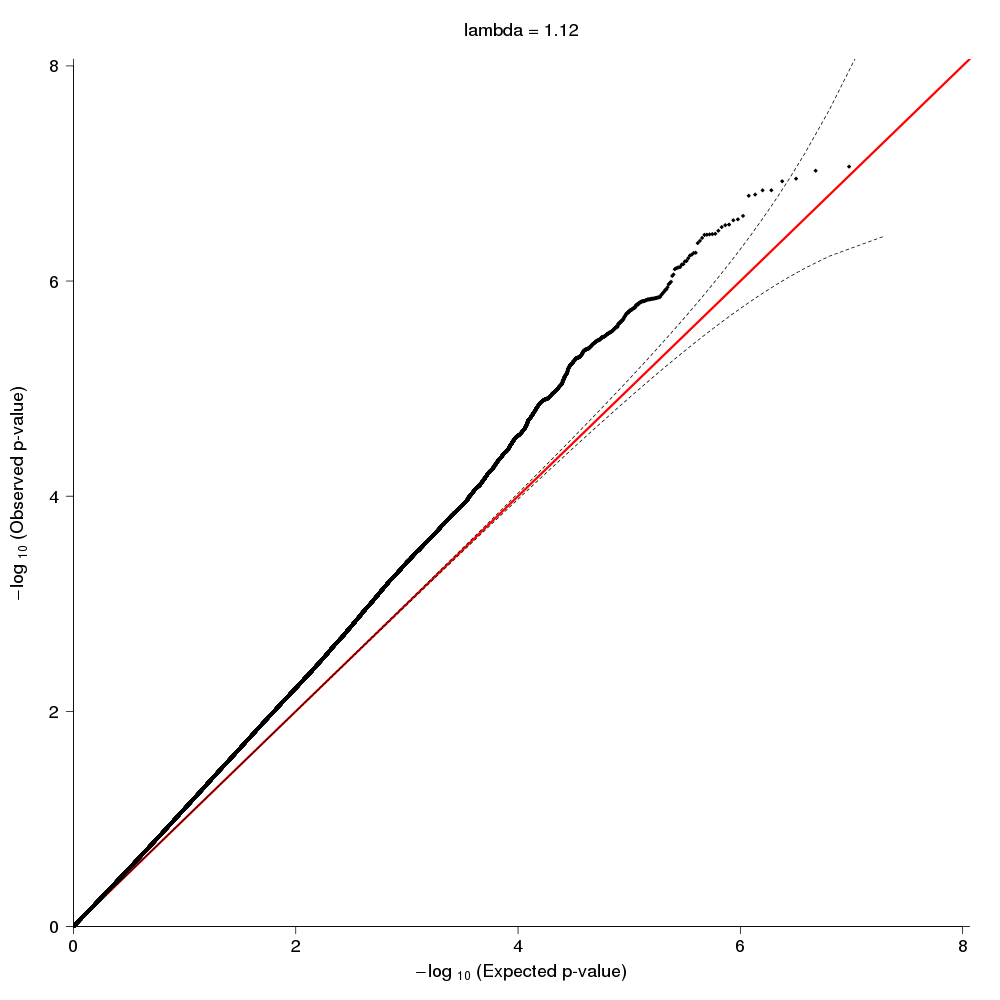

In [7]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/gwas_plots/kreek.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/gwas_plots/kreek.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")

Because the lambda value is inflate for this EA group—indicating possible underlying population structure—we will add more PCs as covariates. Specifically, we will add all of the top 10 PCs as covariates. If there is still inflation, we might have to look into adding additionally covariates to control for drug comorbidity. 

## Version 002
Add all PCs as covariates for the EA GWAS.

### EA GWAS
Add all PCs (1-10)

In [ ]:
# Command line # 
ancestry="ea"
covars="sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10"
version=004

if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi

genD=/shared/data/studies/heroin/kreek/genotype/imputed/20181128/$ancestry
procD=/shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/processing
phenD=/shared/data/studies/heroin/kreek/phenotype/003/final

mkdir -p /shared/data/studies/heroin/kreek/gwas/oaall/$version/$ancestry/{final,processing}

for chr in {1..22};do
    mkdir -p /shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing/chr$chr
done


# Run RVtest
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix $procD/chr$chr/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf $genD/chr${chr}.dose.vcf.gz \
            --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
            --pheno-name oaall \
            --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
            --covar-name $covars \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out $procD/chr$chr/$study.$pop.1000G.oaall.chr$chr
done

## 002 Results Processing
### MAF > 0.01 & Rsq > 0.3
Need to add a filter by population MAF too.

In [ ]:
### EC2 console ###
cd /shared/data/studies/heroin/kreek/gwas/oaall/$version 

# Get list of variants to filter by imputation quality and MAF
#for ancestry in {ea,aa};do
for ancestry in ea;do
    genD=/shared/data/studies/heroin/$study/genotype/imputed/20181128/$ancestry
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry/processing
    phenD=/shared/data/studies/heroin/$study/phenotype/003/final

    for chr in {1..22}; do
        echo -e "${ancestry} chr${chr}..."
        zcat $genD/chr${chr}.info.gz | \
            tail -n +2 | \
            awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
            > $procD/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
    done
done

    

# Filter results files
#for ancestry in {ea,aa}; do
for ancestry in ea;do
    if [ $ancestry == "aa" ]; then
        pop=AFR
    else
        pop=EUR
    fi
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry
    for chr in {1..22}; do
        echo "processing $ancestry chr${chr}..."
        awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
            $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
            <(zgrep -P "^${chr}\s" $procD/processing/chr$chr/${study}.${pop}.1000G.oaall.chr${chr}.MetaScore.assoc.gz) \
            > $procD/processing/chr$chr/${study}.${ancestry}.1000G.oaall.chr${chr}.tmp
    done 
    cat $procD/processing/chr*/${study}.${ancestry}.1000G.oaall.chr*tmp | gzip -c > $procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz

    # cleanup
    rm $procD/processing/chr*/*tmp 
done

# Make results table
#for ancestry in {ea,aa}; do
for ancestry in ea;do
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry
    outfile=$procD/processing/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    infile=$procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz
    echo "Processing ${infile}"
    zcat ${infile} | \
        perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                    } else {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                    }' >> $outfile
done

# Make Q-Q and manhattan plots
# Plot all chromosomes
#for ancestry in {ea,aa};do
for ancestry in ea;do
    procD=/shared/data/studies/heroin/$study/gwas/oaall/$version/$ancestry
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name gwas_plots_${ancestry} \
        --script_prefix $procD/final/${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
        --mem 30 \
        --nslots 7 \
        --priority 0 \
        --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
            --in $procD/processing/$study.$ancestry.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table \
            --in_chromosomes autosomal_nonPAR \
            --in_header \
            --out $procD/final/$study.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
            --col_id VARIANT_ID \
            --col_chromosome CHR \
            --col_position POSITION \
            --col_p P \
            --col_variant_type TYPE \
            --generate_snp_indel_manhattan_plot \
            --manhattan_odd_chr_color red3 \
            --manhattan_even_chr_color dodgerblue3 \
            --manhattan_points_cex 1.5 \
            --generate_snp_indel_qq_plot \
            --qq_lines \
            --qq_points_bg black \
            --qq_lambda
done

### View Plots
#### EA

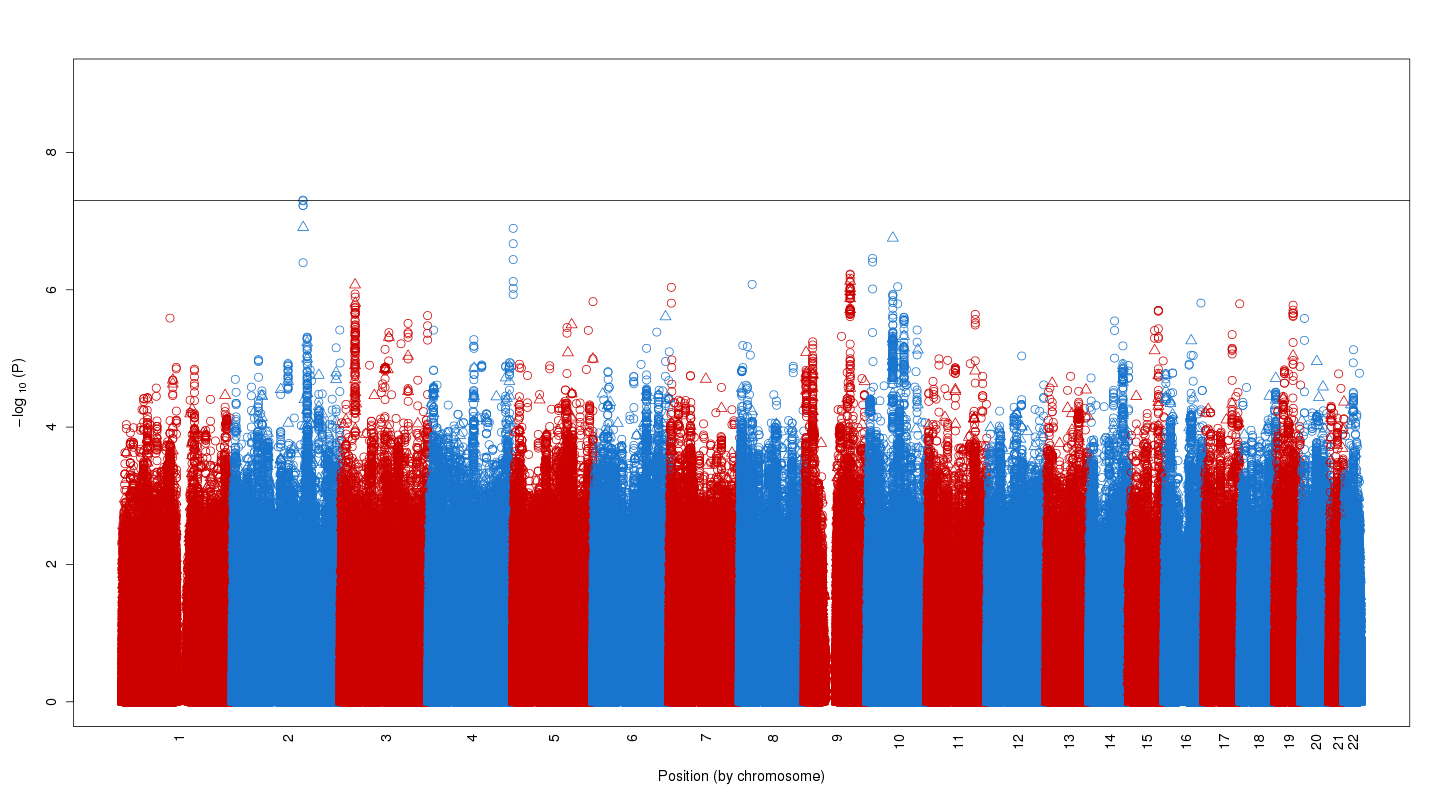

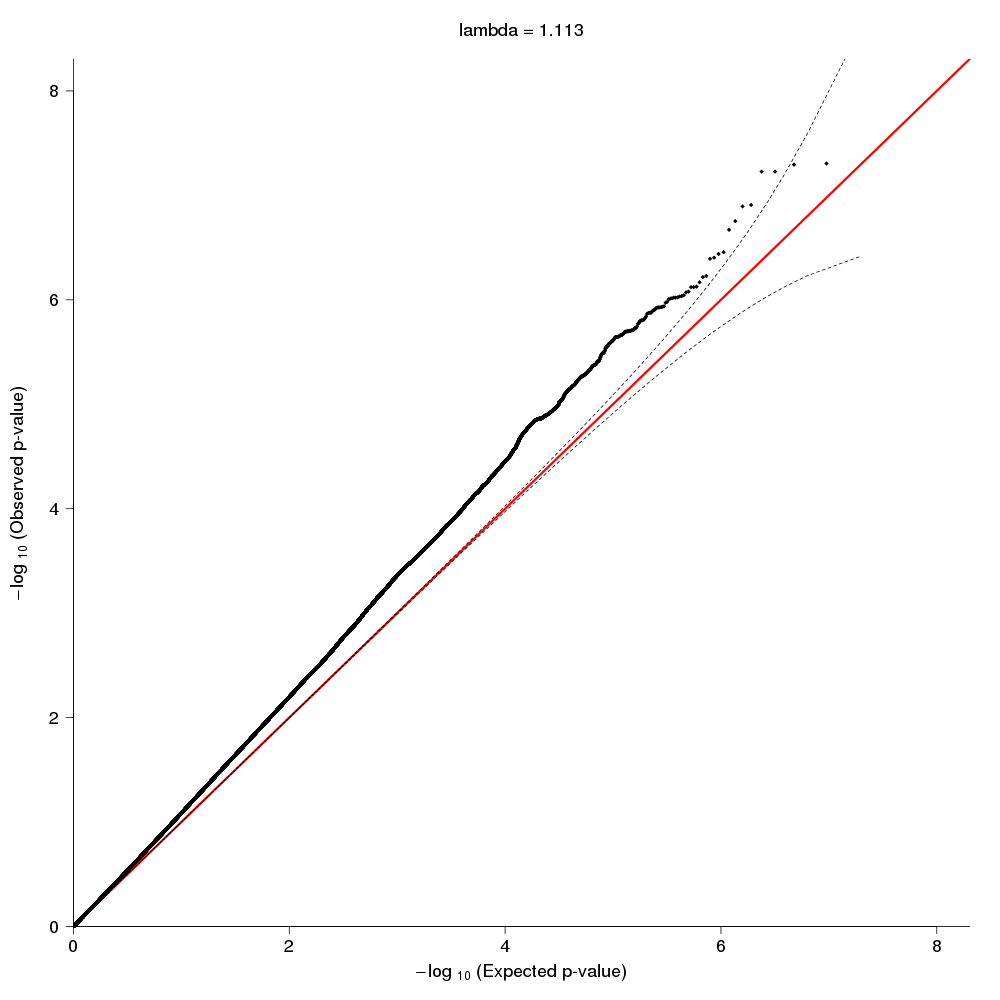

In [9]:
library("IRdisplay")
display_png(file="C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/gwas_plots/002_allpc/kreek.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
display_png(file="C:/Users/jmarks/Desktop/Projects/Heroin/ngc/kreek/20181130/gwas_plots/002_allpc/kreek.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")

# Upload results to S3

In [ ]:
cd /shared/data/studies/heroin/kreek/gwas

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name s3.kreek.upload \
    --script_prefix upload_results \
    --mem 3 \
    --nslots 2 \
    --program aws s3 sync oaall s3://rti-heroin/kreek/results/20281130/oaall/ 